<div class="alert alert-block alert-warning">
    <div style="font-size: 40px; font-weight: bold;">Comparison: RF vs MDS</div>    
    <b>NOTE</b>: This run uses a reduced dataset for the comparison to MDS: the RF in this notebook uses the same data basis and the same variables like in the MDS run.
</div>

<div class="alert alert-block alert-danger">
    <div style="font-size: 40px; font-weight: bold;">N2O Gap-filling based on flag01</div>    
    <b>NOTE</b>: Check the variable `usecols` in `User settings` for info about variables used in this run.
</div>

**Feature Reduction and Gap-filling**

This script uses a datafile containing half-hourly fluxes and meteo data from the research site CH-AES (Aeschi, Switzerland).

Time Periods:
- Measurements 2019: raw data files from `2019051011.X52` to `2019072307.X00`
- Measurements 2020: raw data files from `2020051215.X15` to `2020110307.X00`

# User Settings
- `target` ... column name of the variable for which feature elimination and gap-filling will be performed
- `SELECT_YEAR` ... define year for analyses
- `DATAFILE` ... input, contains the source data
- `OUTFILE` ... output, will contain gap-filled data
- `usecols` ... column names of variables that will be ignored
- `keep_mgmt` ... options: `all` keeps all management, `bulk` keeps combined .MGMT column, `none` removes all management, `combos` keeps combined e.g. Nmin+Norg and also harvest
- `use_timesince_varsuse_timesince_vars` ... calculates e.g. the time since last management event, given as number or half-hours
- `timestamp_as_features` ... add timestamp info as features, e.g. the month is inserted as separate column and used as feature
- `include_rolling_variants` ... add rolling variants of variables as featuresAdd rolling variants of variables as features
- `include_lagged_variants` ... add lagged variants of the rolling variants as features, e.g. the 3-hour average ending 6-hours ago

In [2]:
# Year
SELECT_YEAR = 2019

# Variable of interest
target = 'CH4_flag01_ustar'

# Variables in DATAFILE that will be used, management data must be included here
# but will only be used if `keep_mgmt` is anything other than `none`.
usecols = [
#     'PREC',
    'VPD',
#     'TA', 'Rg', 
#     'RH', 'PA',
    'TS_0.05',
#     'TS_0.15', 'TS_0.30',
    'WFPS_0.05',
#     'WFPS_0.15', 'WFPS_0.30',    
#     'GPP', 'Reco',
#     'NEE_flag0_ustar',
#     'NEE_flag01_ustar',
#     'NEE', 'NEE_flag0', 'NEE_flag01',
#     'N2O_flag01_ustar',
#     'N2O_flag0_ustar',
#     'N2O_flag01', 'N2O_flag0',
    'CH4_flag01_ustar',
#     'CH4_flag0_ustar',
#     'CH4_flag01', 'CH4_flag0',
#     'herb', 'harvest', 'Nmin', 'Norg', 'Nfert', 'soil', 'sow',
#     'veg.height',
#     'lai'
]

# Use management info
keep_mgmt = 'none'  
use_timesince_vars = False

# Random forest settings
timestamp_as_features = False  
include_rolling_variants = False
include_lagged_variants = False

# Files
DATAFILE = "/home/jovyan/work/ms-ch-aes/data/ch-aes-fluxes-co2-n2o-ch4-and-meteo-2019-2020/CH-AES_2019_2020_data_for_analysis_20211205.csv"
OUTFILE = "CH4_gapfilled_2019.C.1_QCF01.csv"

In [3]:
# # Complete list of variables

# usecols = [
#     'PREC',
#     'TA', 'RH', 'PA', 'Rg', 'VPD',
#     'TS_0.05',
#     'TS_0.15', 'TS_0.30',
#     'WFPS_0.05',
#     'WFPS_0.15', 'WFPS_0.30',    
#     'GPP', 'Reco',
#     'NEE_flag0_ustar',
#     'NEE', 'NEE_flag01_ustar', 'NEE_flag0', 'NEE_flag01',
#     'N2O_flag0_ustar',
#     'N2O_flag01', 'N2O_flag0',
#     'CH4_flag0_ustar',
#     'CH4_flag01', 'CH4_flag0',
#     'herb', 'harvest', 'Nmin', 'Norg', 'Nfert', 'soil', 'sow',
#     'veg.height', 'lai'
# ]

# Setup

## Imports

In [4]:
import os
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 99)
pd.set_option('display.max_rows', 99)

import warnings
warnings.filterwarnings('ignore')

from pkgs.randomforest_ts import RandomForestTS  # From DIIVE

In [5]:
print(f"Working directory: {os.getcwd()}")

Working directory: /home/jovyan/work/ms-ch-aes/notebooks


## Load data from file
Load the original data file.

In [6]:
date_parser = lambda c: pd.to_datetime(c, format='%Y-%m-%d %H:%M:%S', errors='coerce')
source_df = pd.read_csv(DATAFILE, index_col=0, parse_dates=True, na_values=[-9999, 'NA'], date_parser=date_parser)
print(f"\nLoaded data from file <b>s</b>{DATAFILE}\n")
print(f"\nData columns with original column names:\n{list(source_df.columns)}\n\n")
display(source_df)


Loaded data from file <b>s</b>/home/jovyan/work/ms-ch-aes/data/ch-aes-fluxes-co2-n2o-ch4-and-meteo-2019-2020/CH-AES_2019_2020_data_for_analysis_20211205.csv


Data columns with original column names:
['TA', 'RH', 'PA', 'Rg', 'TS_0.05', 'TS_0.15', 'TS_0.30', 'WFPS_0.05', 'WFPS_0.15', 'WFPS_0.30', 'PREC', 'VPD', 'GPP', 'Reco', 'NEE_gfMDS', 'NEE_flag0', 'NEE_flag0_ustar', 'NEE_flag01', 'NEE_flag01_ustar', 'N2O_gfMDS', 'N2O_flag0', 'N2O_flag01', 'N2O_flag0_ustar', 'N2O_flag01_ustar', 'CH4_gfMDS', 'CH4_flag0', 'CH4_flag01', 'CH4_flag0_ustar', 'CH4_flag01_ustar', 'herb', 'harvest', 'Nmin', 'Norg', 'Nfert', 'soil', 'sow', 'veg.height', 'lai']




,TA,RH,PA,Rg,TS_0.05,TS_0.15,...,Norg,Nfert,soil,sow,veg.height,lai
TIMESTAMP,,,,,,,,,,,,,
2019-05-10 00:45:00,8.733333,93.166667,95.546667,0.0,9.900000,10.300000,...,0,0,0,0,0.744054,0.046647
2019-05-10 01:15:00,8.866667,93.200000,95.563333,0.0,9.833333,10.266667,...,0,0,0,0,0.755604,0.047353
2019-05-10 01:45:00,8.766667,94.366667,95.580000,0.0,9.800000,10.200000,...,0,0,0,0,0.767162,0.048060
2019-05-10 02:15:00,8.566667,96.266667,95.583333,0.0,9.800000,10.133333,...,0,0,0,0,0.778729,0.048767
2019-05-10 02:45:00,8.366667,97.666667,95.603333,0.0,9.700000,10.033333,...,0,0,0,0,0.790305,0.049474
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-03 10:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0.000000,0.000000
2020-11-03 11:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0.000000,0.000000
2020-11-03 11:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0.000000,0.000000


### Sanitize original timestamp

**Check timestamp index for erroneous timestamps**:
Timestamp is checked for duplicates and timestamp NaTs ("not a time").

In [7]:
# Remove duplicates, keep first
locs_duplicates = source_df.index.duplicated(keep='first')
print(f"Found duplicates in index: {locs_duplicates.sum()}")
source_df = source_df[~locs_duplicates]

# Remove NaTs
locs_nats = source_df.index.isnull()
print(f"Found duplicates in index: {locs_nats.sum()}")
source_df = source_df[~locs_nats]

Found duplicates in index: 1
Found duplicates in index: 1


**Sort timestamp**: ascending order

In [8]:
# Sort timestamp index
source_df = source_df.sort_index(ascending=True)

### Check data

**Data description**:

In [9]:
source_df.describe()

,TA,RH,PA,Rg,TS_0.05,TS_0.15,...,Norg,Nfert,soil,sow,veg.height,lai
count,24395.000000,24409.000000,24399.000000,24447.000000,23873.000000,23873.000000,...,26087.000000,26087.000000,26087.000000,26087.000000,26087.000000,26087.000000
mean,12.947905,75.984155,96.178601,160.945641,15.252886,15.148301,...,0.001840,0.002760,0.003680,0.001840,46.081476,0.688994
std,7.464909,17.022747,0.682185,239.723086,6.821596,6.163158,...,0.042857,0.052464,0.060552,0.042857,99.885232,1.233440
min,-5.333333,24.966667,92.886667,0.000000,1.900000,3.002778,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.468611,63.217778,95.852969,0.000000,10.233889,10.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.666667,81.033333,96.250000,14.333333,15.260555,15.523889,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.033333,90.366667,96.581394,253.005560,20.116667,20.254999,...,0.000000,0.000000,0.000000,0.000000,18.045224,0.634141
max,36.200000,100.400000,98.096667,959.649957,38.166667,31.100000,...,1.000000,1.000000,1.000000,1.000000,323.071936,4.180000


**Available values by year**:

In [10]:
source_df.groupby(source_df.index.year).count()

,TA,RH,PA,Rg,TS_0.05,TS_0.15,...,Norg,Nfert,soil,sow,veg.height,lai
TIMESTAMP,,,,,,,,,,,,,
2019,11239,11239,11239,11253,11180,11180,...,11327,11327,11327,11327,11327,11327
2020,13156,13170,13160,13194,12693,12693,...,14760,14760,14760,14760,14760,14760


## Prepare work dataset
Prepare dataset with reduced number of variables.  

**Copy**: always work on a copy, the loaded original data (`source_df`) remains untouched

In [11]:
# Make a copy
df = source_df.copy()

### Select columns and range

Remove unneeded columns:

In [12]:
df = df[usecols].copy()
# df.drop(dropcols, axis=1, inplace=True)

Rename the target column to 'target':

In [13]:
# Define and rename target column
df.rename(columns={target: 'target'}, inplace=True)

Get datetime of first and last available measurement of target:

In [14]:
_first_target_value_dt = df['target'].dropna().index[0]
_last_target_value_dt = df['target'].dropna().index[-1]
print(f"First measured value of target: {_first_target_value_dt}")
print(f"Last measured value of target: {_last_target_value_dt}")
print(f"Maximum value in target: {df['target'].max()}")
print(f"Minimum value in target: {df['target'].min()}")

First measured value of target: 2019-05-10 12:15:00
Last measured value of target: 2020-11-03 08:15:00
Maximum value in target: 0.353205
Minimum value in target: -0.183057


### Convert flux units
- from `umol m-2 s-1` to `nmol m-2 s-1`:

In [15]:
factor = 1000
if not 'NEE' in target:  # Do not convert for CO2 flux
    df['target'] = df['target'].multiply(factor)  
    print(f"Multiplied {target} by {factor}")
else:
    print(f"No conversion for {target}")        

Multiplied CH4_flag01_ustar by 1000


#### Check variables in work dataset

In [16]:
df.columns

Index(['VPD', 'TS_0.05', 'WFPS_0.05', 'target'], dtype='object')

In [17]:
pd.set_option('display.max_columns', 99)
pd.set_option('display.max_rows', 99)
display(df.head(3))
display(df.columns)

,VPD,TS_0.05,WFPS_0.05,target
TIMESTAMP,,,,
2019-05-10 00:45:00,NaN,9.900000,56.778792,NaN
2019-05-10 01:15:00,NaN,9.833333,56.993574,NaN
2019-05-10 01:45:00,NaN,9.800000,57.306502,NaN


Index(['VPD', 'TS_0.05', 'WFPS_0.05', 'target'], dtype='object')

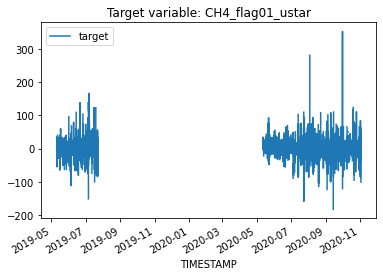

In [18]:
df[['target']].plot(title=f"Target variable: {target}");

# Random Forest

## Prepare Data Subset
Make subset of data that is used in RF.

In [19]:
# Make copy to work with
subset_df = df.copy()

In [20]:
# Select year
subset_df = subset_df.loc[subset_df.index.year == SELECT_YEAR]
  
if SELECT_YEAR == 2020:
    start_date = pd.to_datetime('2020-01-01 00:15:00')
    end_date = pd.to_datetime('2020-09-15 00:15')  # new in v7, stops on day of harvest for this analysis
elif SELECT_YEAR == 2019:
    start_date = pd.to_datetime('2019-01-01 00:15:00')
    end_date = pd.to_datetime('2019-07-03 00:15') # new in v7, stops on day of harvest for this analysis

subset_df['temp_datetime_col'] = subset_df.index
subset_df.loc[(subset_df['temp_datetime_col'] > start_date) & (subset_df['temp_datetime_col'] < end_date)]  
subset_df = subset_df[subset_df['temp_datetime_col'].between(start_date, end_date)]
subset_df = subset_df.drop('temp_datetime_col', axis=1)

# Datetime of first and last available measurement of target
_first_target_value_dt = subset_df['target'].dropna().index[0]
_last_target_value_dt = subset_df['target'].dropna().index[-1]
print(f"First measured value of target: {_first_target_value_dt}")
print(f"Last measured value of target: {_last_target_value_dt}")

# Restrict time range to first and last available data point of target
subset_df = subset_df.loc[_first_target_value_dt:_last_target_value_dt]

First measured value of target: 2019-05-10 12:15:00
Last measured value of target: 2019-07-02 13:45:00


In [21]:
# Add second header row, needed for RandomForestTS class
lst_for_empty_units = []
for e in range(len(subset_df.columns)):  ## generate entry for all cols in df
    lst_for_empty_units.append('-')
subset_df.columns = [subset_df.columns, lst_for_empty_units]  ## conv column index to multiindex

## Model setup

In [22]:
target_col = ('target', '-')
rfts = RandomForestTS(df=subset_df,
                      target_col=target_col,
                      verbose=1,
                      random_state=42,
                      rfecv_step=1,
                      rfecv_min_features_to_select=20,
                      rf_rfecv_n_estimators=100,
                      rf_n_estimators=1000,
                      bootstrap=True)

## Rolling Variants

In [23]:
if include_rolling_variants:
    
    # No rolling variants for some vars
    _donotroll_ids = ['.timesince', '.MGMT', '.ploughing',  '.soilprep', '.Norg', '.Nmin', '.harvest', '.sowing', '.daynight', 'veg.height', 'lai']
    donotroll_cols = [target_col]
    for col in rfts.df.columns:
        if any(_donotroll_id in col[0] for _donotroll_id in _donotroll_ids):
            donotroll_cols.append(col)
    
    rfts.rolling_variants(records=6,
                          aggtypes=['mean'],
                          exclude_cols=donotroll_cols)    
else:
    print("No rolling variants calculated.")

No rolling variants calculated.


In [24]:
rfts.df.columns

MultiIndex([(      'VPD', '-'),
            (  'TS_0.05', '-'),
            ('WFPS_0.05', '-'),
            (   'target', '-')],
           )

## Lagged Variants

In [25]:
if include_lagged_variants:       
    
    if include_rolling_variants:
        # Create lagged variants for rolling variants only
        exclude_cols = []
        [exclude_cols.append(col) for col in rfts.df.columns if 'r-' not in col[0]]
        exclude_cols.append(['veg.height', 'lai'])
        print(f"No lagged variants will be created for the following columns:{exclude_cols}\n")
    
    rfts.steplagged_variants(stepsize=6,
                             stepmax=24,
                             exclude_cols=exclude_cols)
else:
    print("No lagged variants calculated.")

No lagged variants calculated.


In [26]:
list(rfts.df.columns)

[('VPD', '-'), ('TS_0.05', '-'), ('WFPS_0.05', '-'), ('target', '-')]

## Add Timestamp As Features

In [27]:
if timestamp_as_features:
    rfts.include_timestamp_as_features(doy_as_feature=True,
                                       week_as_feature=True,
                                       month_as_feature=True,
                                       hour_as_feature=True)

## Check

In [28]:
# [print(col) for col in rfts.df.columns]
pd.set_option('display.max_columns', 99)
pd.set_option('display.max_rows', 99)
display(rfts.df)
columns_in_dataset = list(rfts.df.columns)
# [print(col) for col in columns_in_dataset]
columns_in_dataset

,VPD,TS_0.05,WFPS_0.05,target
,-,-,-,-
TIMESTAMP,,,,
2019-05-10 12:15:00,401.721,13.700000,57.666247,-4.69694
2019-05-10 12:45:00,484.515,14.266667,57.503041,-3.89009
2019-05-10 13:15:00,528.064,14.833333,57.429442,-4.85069
2019-05-10 13:45:00,597.418,15.533333,57.298300,29.35430
2019-05-10 14:15:00,671.624,15.900000,57.257234,7.82501
...,...,...,...,...
2019-07-02 11:45:00,1046.580,28.700000,32.396448,10.83410
2019-07-02 12:15:00,1117.060,29.466667,32.456118,6.71455


[('VPD', '-'), ('TS_0.05', '-'), ('WFPS_0.05', '-'), ('target', '-')]

In [29]:
# rfts.df.plot(figsize=(16, 9), subplots=True);

## Feature Reduction
Identify most important features for predicting target.

In [30]:
rfts.feature_reduction()
reduced_df, feat_reduction_results = rfts.get_reduced_dataset()



[FEATURE REDUCTION]    START ==============================
[FEATURE REDUCTION]    Parameters:  {'cv': TimeSeriesSplit(max_train_size=None, n_splits=5), 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'mse', 'estimator__max_depth': None, 'estimator__max_features': 'auto', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': -1, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestRegressor(n_jobs=-1, random_state=42), 'min_features_to_select': 20, 'n_jobs': -1, 'scoring': 'explained_variance', 'step': 1, 'verbose': 1}
[FEATURE REDUCTION]    Number of features *before* reduction:  3
[FEATURE REDUCTION]    

In [31]:
feat_reduction_results['feature_importances_after'].loc[feat_reduction_results['feature_importances_after']['importance'] > 0.01]

,feature,importance
0,"(VPD, -)",0.361305
2,"(WFPS_0.05, -)",0.340357
1,"(TS_0.05, -)",0.298338


## Build Final Model

In [32]:
rfts.build_final_model()



[FINAL MODEL]    START ==============================
[FINAL MODEL]    Target column:  ('target', '-')  (1904 values)
[FINAL MODEL]    Number of features used in model:  3
[FINAL MODEL]    Names of features used in model:  [('VPD', '-'), ('WFPS_0.05', '-'), ('TS_0.05', '-')]
[FINAL MODEL]    Model parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
[FINAL MODEL]    Model MAE:  3.883571367154412
[FINAL MODEL]    Model MAPE:  -1.563%
[FINAL MODEL]    Model R2:  0.8479891009249051
[FINAL MODEL]    Model features:
              Var  Importance
0        (VPD, -)        0.36
1  (WFPS_0.05, -)        0.35
2    (TS_0.05, -)        0.30
[FINAL

## Fill gaps
Fill gaps in target variable, using the model with reduced features.

In [33]:
rfts.gapfilling()
gapfilled_df, gf_results = rfts.get_gapfilled_dataset()



[GAPFILLING]    START ==============================
Added timestamp as columns: [('.DOY', '[day_of_year]'), ('.WEEK', '[week_of_year]'), ('.MONTH', '[month]'), ('.HOUR', '[hour]')]
[GAPFILLING]    feature_names:  [('VPD', '-'), ('WFPS_0.05', '-'), ('TS_0.05', '-')]
[GAPFILLING]    num_features:  3
[GAPFILLING]    first_timestamp:  2019-05-10 12:15:00
[GAPFILLING]    last_timestamp:  2019-07-02 13:45:00
[GAPFILLING]    max_potential_vals:  2548
[GAPFILLING]    target_numvals:  1988
[GAPFILLING]    target_numgaps:  560
[GAPFILLING]    target_gapfilled_numvals:  2548
[GAPFILLING]    target_gapfilled_numgaps:  0
[GAPFILLING]    target_gapfilled_flag_notfilled:  1988
[GAPFILLING]    target_gapfilled_flag_with_hq:  527
[GAPFILLING]    target_gapfilled_flag_with_fallback:  33
[GAPFILLING]    predictions_hq_numvals:  2431
[GAPFILLING]    predictions_hq_numgaps:  117
[GAPFILLING]    predictions_fallback_numvals:  2548
[GAPFILLING]    predictions_fallback_numgaps:  0
[GAPFILLING]    =========

In [34]:
gapfilled_df

,target,.predictions,.gap_predictions,QCF_target#gfRF,target#gfRF,.predictions_fallback,.gapfilled_cumulative
,-,[aux],[aux],[0=measured],-,[aux],[aux]
TIMESTAMP,,,,,,,
2019-05-10 12:15:00,-4.69694,-3.560981,NaN,0,-4.69694,-2.941363,-4.696940
2019-05-10 12:45:00,-3.89009,-3.220890,NaN,0,-3.89009,-2.941363,-8.587030
2019-05-10 13:15:00,-4.85069,-1.416600,NaN,0,-4.85069,10.283374,-13.437720
2019-05-10 13:45:00,29.35430,20.343080,NaN,0,29.35430,10.283374,15.916580
2019-05-10 14:15:00,7.82501,10.289961,NaN,0,7.82501,7.198598,23.741590
...,...,...,...,...,...,...,...
2019-07-02 11:45:00,10.83410,7.985628,NaN,0,10.83410,0.637318,1679.684656
2019-07-02 12:15:00,6.71455,5.169776,NaN,0,6.71455,-0.876055,1686.399206


## Save To File

In [35]:
gapfilled_df.to_csv(OUTFILE)

## Summary

In [36]:
gf_results

{'feature_names': [('VPD', '-'), ('WFPS_0.05', '-'), ('TS_0.05', '-')],
 'num_features': 3,
 'first_timestamp': Timestamp('2019-05-10 12:15:00'),
 'last_timestamp': Timestamp('2019-07-02 13:45:00'),
 'max_potential_vals': 2548,
 'target_numvals': 1988,
 'target_numgaps': 560,
 'target_gapfilled_numvals': 2548,
 'target_gapfilled_numgaps': 0,
 'target_gapfilled_flag_notfilled': 1988,
 'target_gapfilled_flag_with_hq': 527,
 'target_gapfilled_flag_with_fallback': 33,
 'predictions_hq_numvals': 2431,
 'predictions_hq_numgaps': 117,
 'predictions_fallback_numvals': 2548,
 'predictions_fallback_numgaps': 0}

In [37]:
# Flag info
_flag = gapfilled_df[('QCF_target#gfRF', '[0=measured]')]
_unique_values = pd.unique(_flag.values.ravel())
_counts_series = pd.Series(index=_unique_values, dtype=int)
_counts_series = _flag.value_counts(dropna=False)
_counts_series

0    1988
1     527
2      33
Name: (QCF_target#gfRF, [0=measured]), dtype: int64

In [38]:
list(gapfilled_df.columns)

[('target', '-'),
 ('.predictions', '[aux]'),
 ('.gap_predictions', '[aux]'),
 ('QCF_target#gfRF', '[0=measured]'),
 ('target#gfRF', '-'),
 ('.predictions_fallback', '[aux]'),
 ('.gapfilled_cumulative', '[aux]')]

### Plot: Overview

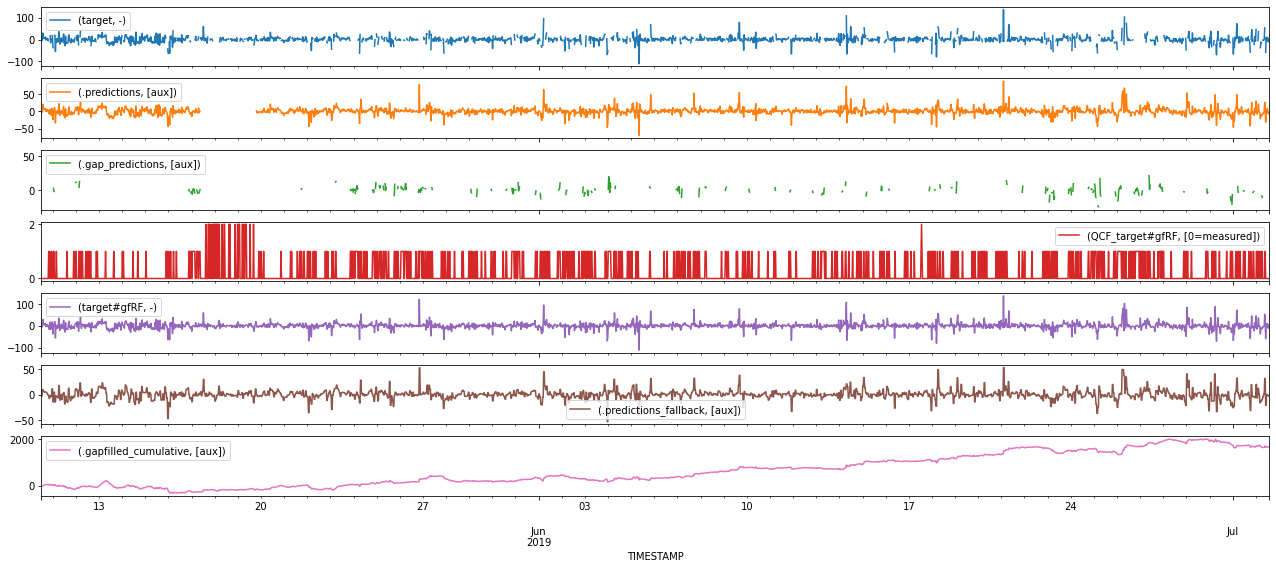

In [39]:
gapfilled_df.plot(subplots=True, figsize=(22, 9));

### Plot: Predictions vs. Target

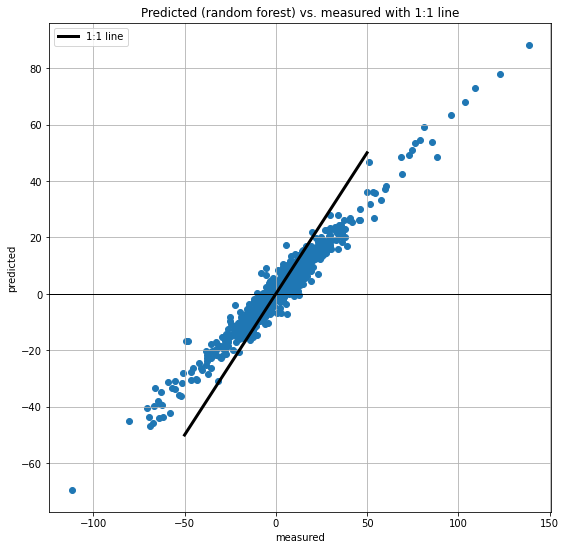

In [40]:
# Plot all targets vs. predictions
x_col = ('target', '-')
y_col = ('.predictions', '[aux]')
plt.figure(figsize=(9, 9))
plt.scatter(gapfilled_df[x_col], gapfilled_df[y_col])
plt.title("Predicted (random forest) vs. measured with 1:1 line")
plt.axhline(0, color='black', lw=1)
plt.plot([-50,50],[-50,50], 'black', linewidth=3, label="1:1 line", ls="-")
plt.xlabel("measured")
plt.ylabel("predicted")
# plt.xlim(-70, 20)
# plt.ylim(-70, 20)
plt.grid()
plt.legend();

### Plot: Measured And Gap-filled Values

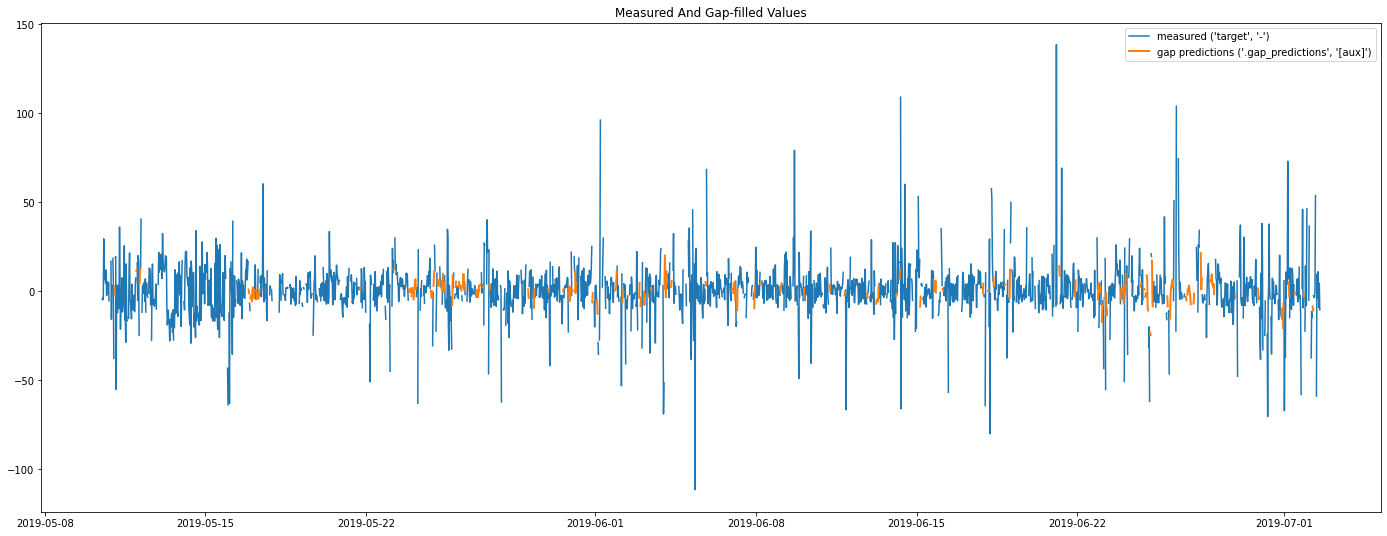

In [41]:
# Plot all targets and predictions
x_col = ('target', '-')
y_col = ('.gap_predictions', '[aux]')
plt.figure(figsize=(24, 9))
plt.title("Measured And Gap-filled Values")
plt.plot(gapfilled_df[x_col], label=f"measured {x_col}")
plt.plot(gapfilled_df[y_col], label=f"gap predictions {y_col}", lw=2)
plt.legend()
plt.show()

### Plot: Gap-filled Time Series

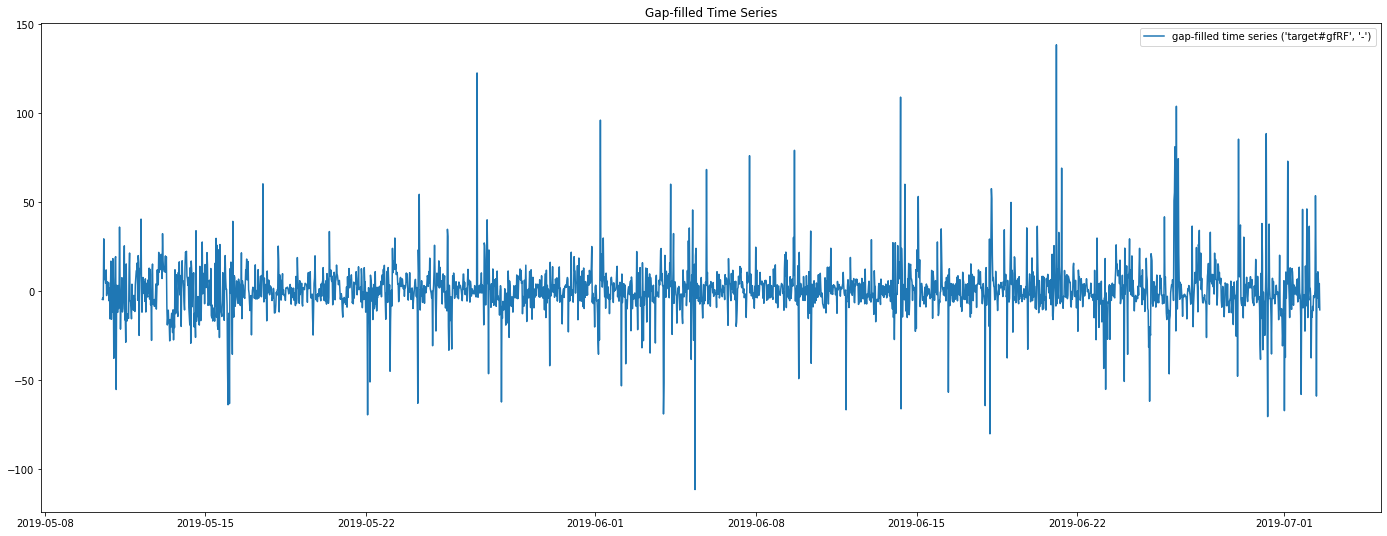

In [42]:
col = ('target#gfRF', '-')
plt.figure(figsize=(24, 9))
plt.title("Gap-filled Time Series")
plt.plot(gapfilled_df[col], label=f"gap-filled time series {col}")
plt.legend()
plt.show()

### Visualize tree

In [42]:
# # Visualize one of the decision trees
# from sklearn.tree import export_graphviz
# import pydot
# tree = rfts.model.estimators_[2]  # # Pull out one tree from the forest
# export_graphviz(tree, out_file = 'tree.dot', feature_names=rfts.feature_names, rounded = True, precision = 1)  # Export the image to a dot file
# (graph, ) = pydot.graph_from_dot_file('tree.dot')  # Use dot file to create a graph
# graph.write_png('tree.png')  # Write graph to a png file

In [43]:
# rfts.feat_reduction_results

## Kudos

- kudos: https://stackoverflow.com/questions/26911851/how-to-use-pandas-to-find-consecutive-same-data-in-time-series
- https://bambielli.com/til/2018-02-11-one-hot-encoding/
- https://www.educative.io/blog/one-hot-encoding#sklearn